# Toxic Comment Dataset – Data Preparation & Exploration

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

Our Goal is to create a Deep learning model to detect toxicity and to classify them.

Goal of this notebook:
- Load the raw training data
- Inspect the structure of the dataset
- Explore the label distribution (multi-label problem)
- Look at text length and basic properties
- Apply a light, model-friendly text cleaning
- Save a clean version of the dataset (and optional train/valid split)

The idea is to keep the text close to its original form (good for Transformers)
while removing the worst noise (line breaks, extra spaces, raw URLs, HTML tags)

# Basic setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import unicodedata
from sklearn.metrics import (
    f1_score,
    classification_report,
    precision_recall_fscore_support,
    confusion_matrix,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

# Plot style
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# Reproductibilité
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Imports terminés.")

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Imports terminés.
Using device: mps


# Dataset Preprocessing

## Import Dataset

In [2]:
file_path = "data/train.csv"

# Read file (try common encodings)
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
print("Shape:", df.shape)
df.head()

Shape: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Quick look

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In this dataset, each comment can have multiple labels:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate
  
This is a multi-label classification problem (not just one class per row).

This is a multi-label setup: each comment can belong to several categories at the same time
(e.g. both `toxic` and `insult`). This will influence the choice of loss function later
(sigmoid outputs + binary cross-entropy instead of a softmax).

Check for missing values in the main columns.

In [4]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

df[["id", "comment_text"] + label_cols].isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## Label Distribution

First, let's count how many times each label appears.

Counts (0 vs 1) for each label


,count_0,count_1
label,,
toxic,144277,15294
severe_toxic,157976,1595
obscene,151122,8449
threat,159093,478
insult,151694,7877
identity_hate,158166,1405


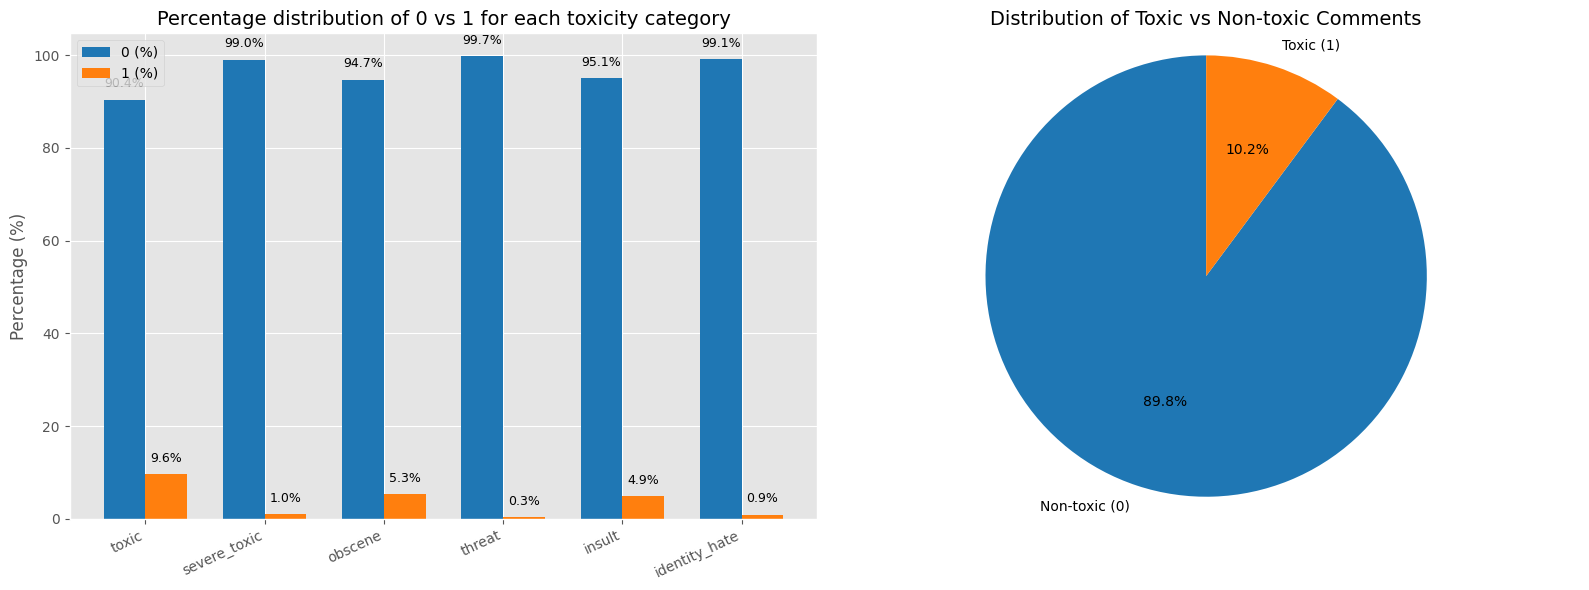

In [5]:
# Create a binary 'detect_toxic' column:
# 1 if the text is classified as toxic in at least one category (any 1 in label_cols),
# 0 if it is not toxic in any category.
df['detect_toxic'] = df[label_cols].max(axis=1).astype(int)


# Compute counts for 0 and 1 for each label
counts = []
for c in label_cols:
    vc = df[c].value_counts().to_dict()
    counts.append({'label': c, 'count_0': vc.get(0, 0), 'count_1': vc.get(1, 0)})
counts_df = pd.DataFrame(counts).set_index('label')

print("Counts (0 vs 1) for each label")
display(counts_df)


# Compute percentages for each label (avoid division by zero)
total_per_label = counts_df['count_0'] + counts_df['count_1']
total_per_label = total_per_label.replace(0, np.nan)  # avoid div by zero
pct_0 = (counts_df['count_0'] / total_per_label) * 100
pct_1 = (counts_df['count_1'] / total_per_label) * 100
pct_0 = pct_0.fillna(0)
pct_1 = pct_1.fillna(0)

# Summary table with counts + percentages (optional display)
summary_df = counts_df.copy()
summary_df['pct_0'] = pct_0.round(1)
summary_df['pct_1'] = pct_1.round(1)


# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot grouped bar chart (percentages) on the left subplot
labels = counts_df.index.tolist()
count_0_pct = pct_0.values
count_1_pct = pct_1.values

x = np.arange(len(labels))
width = 0.35

# Colors (blue/orange)
color_0 = '#1f77b4'  # blue
color_1 = '#ff7f0e'  # orange

ax1.bar(x - width/2, count_0_pct, width, label='0 (%)', color=color_0)
ax1.bar(x + width/2, count_1_pct, width, label='1 (%)', color=color_1)

ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=25, ha='right')
ax1.set_ylabel('Percentage (%)')
ax1.set_title('Percentage distribution of 0 vs 1 for each toxicity category')
ax1.legend()

# Annotate percentages on top of bars
y_offset = max(np.max(count_0_pct), np.max(count_1_pct)) * 0.02 if len(labels) > 0 else 1
for i in range(len(x)):
    ax1.text(x[i] - width/2, count_0_pct[i] + y_offset, f"{count_0_pct[i]:.1f}%", 
             ha='center', va='bottom', fontsize=9)
    ax1.text(x[i] + width/2, count_1_pct[i] + y_offset, f"{count_1_pct[i]:.1f}%", 
             ha='center', va='bottom', fontsize=9)


# Pie chart for detect_toxic (also blue/orange)
if 'detect_toxic' in df.columns:
    toxic_counts = df['detect_toxic'].value_counts()
    sizes = [int(toxic_counts.get(0, 0)), int(toxic_counts.get(1, 0))]

    if sum(sizes) == 0:
        ax2.text(0.5, 0.5, "No data for 'detect_toxic'", ha='center', va='center')
    else:
        pie_labels = ['Non-toxic (0)', 'Toxic (1)']
        ax2.pie(
            sizes,
            labels=pie_labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=[color_0, color_1]   # <-- Blue & Orange
        )
        ax2.axis('equal')
        ax2.set_title('Distribution of Toxic vs Non-toxic Comments')
        # print(f"Non-toxic (0): {sizes[0]}")
        # print(f"Toxic (1): {sizes[1]}")
else:
    ax2.text(0.5, 0.5, "Column 'detect_toxic' not found", ha='center', va='center')

plt.tight_layout()
plt.show()

### Note on label imbalance

The label distribution is very  skewed. Some labels like `toxic` are relatively frequent,
while others such as `severe_toxic`, `threat` or `identity_hate` are rare.

This has a few consequences for the next phases of the project:

- A simple accuracy score will be misleading.
- The model may focus on the frequent labels and almost ignore the rare ones.
- Metrics for rare labels will be noisy, especially on a small validation set.

Later, during training, I will need to:
- Track per-label metrics (F1, precision, recall).
- Consider using class weights, focal loss or some form of oversampling for rare labels.
- Tune thresholds per label instead of using a single 0.5 cut-off.

### How many labels per comment?

For each comment, we can count how many labels are active (0 to 6).

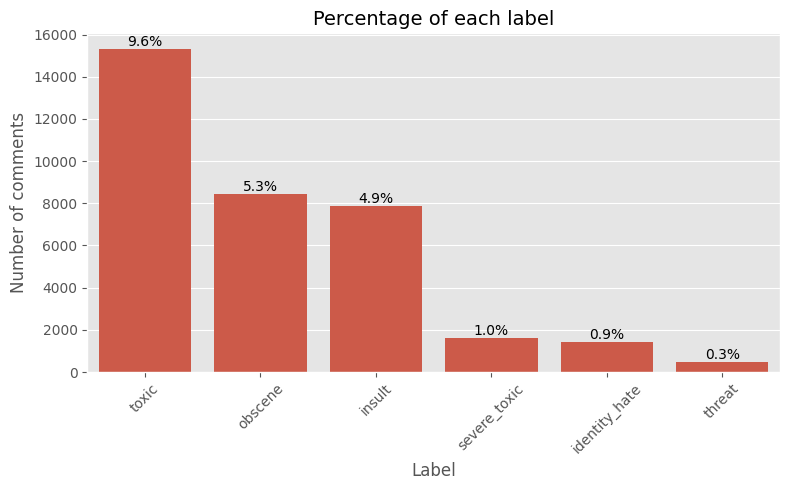

In [6]:
label_counts = df[label_cols].sum().sort_values(ascending=False)
total = len(df)

# Plot label counts as a bar chart.
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)

# Ajouter les pourcentages au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    percent = (height / total) * 100
    ax.annotate(
        f"{percent:.1f}%",                      # format pourcentage
        (p.get_x() + p.get_width() / 2, height),
        ha='center', va='bottom', fontsize=10
    )

plt.title("Percentage of each label")
plt.ylabel("Number of comments")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Text length analysis

It's useful to know how long the comments are.
This helps decide on a maximum sequence length for the model later.

### Per character

We count by character every comment to see the repartition

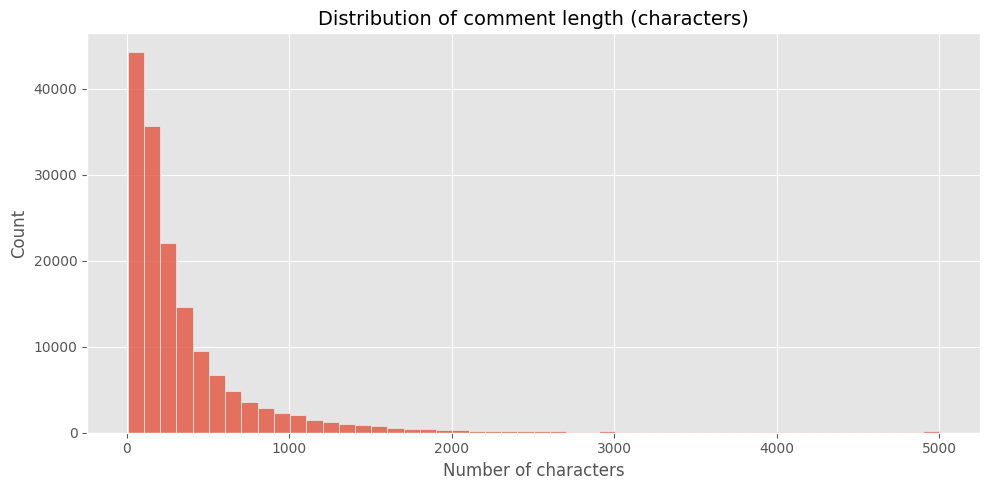

In [7]:
df["text_length"] = df["comment_text"].astype(str).str.len()

# plot the distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["text_length"], bins=50)
plt.title("Distribution of comment length (characters)")
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We can also compare length distributions between toxic and non-toxic, using the column detect_toxic label .

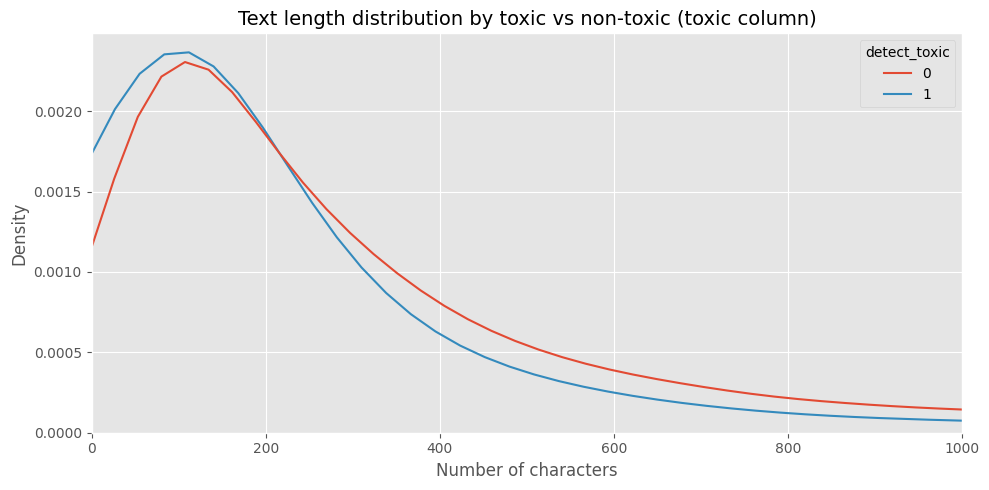

In [8]:
plt.figure(figsize=(10, 5))
sns.kdeplot(
    data=df,
    x="text_length",
    hue="detect_toxic",
    common_norm=False,
    bw_adjust=1.2,
)
plt.xlim(0, 1000)  # limit for readability
plt.title("Text length distribution by toxic vs non-toxic (toxic column)")
plt.xlabel("Number of characters")
plt.tight_layout()
plt.show()

### Per word

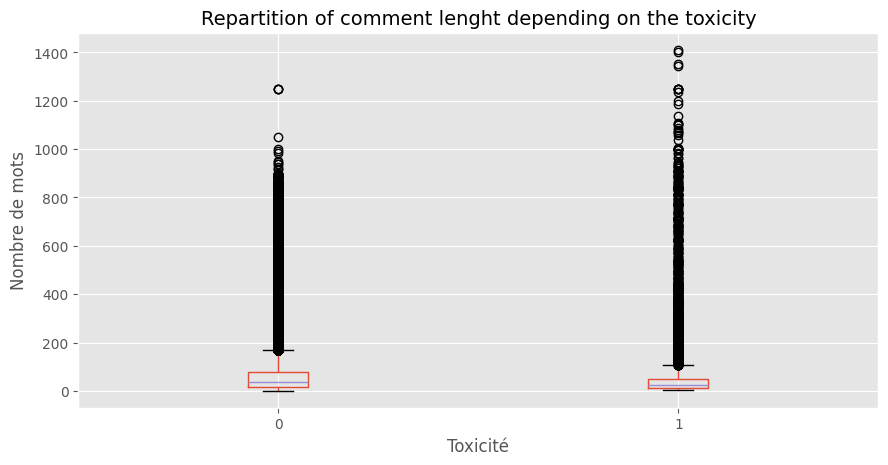

In [9]:
# I want to know the number of word in every comment to know the average
df["nb_mots"] = df["comment_text"].str.split().str.len()

#test to check the relation between comment lenght and comment toxicity
df.boxplot(column="nb_mots", by="detect_toxic")
plt.title("Repartition of comment lenght depending on the toxicity")
plt.suptitle("")
plt.xlabel("Toxicité")
plt.ylabel("Nombre de mots")
plt.show()

We notice that there is no relation between Toxicity message and number of words or number of charcters. We could add or delete word. There will not have impact on our prediction

## Text Cleaning

In [10]:
# Pre-compiled regex patterns for performance
RE_URL = re.compile(r'https?://\S+|www\.\S+', flags=re.IGNORECASE)  # Detect URLs
RE_IP = re.compile(r'(([0-9]{1,3}\.){2,}[0-9]{1,3})')               # Detect IP addresses (basic IPv4 format)
RE_SYM_REPEAT = re.compile(r'([*!?.,;:()\[\]"\-—–])\1{2,}')         # Symbol repeated 3+ times
RE_LETTER_REPEAT = re.compile(r'([^\W\d_])\1{2,}', flags=re.UNICODE)  # Letter repeated 3+ times
RE_MULTI_SPACE = re.compile(r'\s{2,}')                              # Multiple spaces

def normalize_unicode(text):
    """
    Normalize unicode characters to a consistent representation (NFKC).
    This preserves accents while normalizing different forms of the same character.
    """
    return unicodedata.normalize('NFKC', text)

def clean_text_series(s: pd.Series,
                      lower: bool = True,
                      url_token: str = "[URL]",
                      ip_token: str = "[IP]",
                      max_letter_repeats: int = 2,
                      keep_sym_repeat_max: int = 3) -> pd.Series:
    """
    Clean a pandas Series of text efficiently using vectorized operations.

    Parameters:
    - lower: convert text to lowercase (disable for case-sensitive language models like BERT-base-cased)
    - url_token: token replacing detected URLs (keeps semantic value)
    - ip_token: token replacing detected IP addresses
    - max_letter_repeats: limit for character repetitions (e.g., "fuuuuck" → "fuuck" if set to 2)
    - keep_sym_repeat_max: limit for punctuation repetitions (e.g., "!!!!!" → "!!!")
    """

    s = s.astype(str).fillna("")   # Ensure text format + remove NaN
    s = s.map(normalize_unicode)   # Normalize unicode representation

    if lower:
        s = s.str.lower()

    # Replace URLs without adding extra whitespace
    s = s.str.replace(RE_URL, url_token, regex=True)

    # Replace IPs
    s = s.str.replace(RE_IP, ip_token, regex=True)

    # Remove newlines instead of replacing by token with spaces
    s = s.str.replace(r'\r\n|\r|\n', ' ', regex=True)

    # Reduce repeating punctuation marks
    def sym_repl(m):
        return m.group(1) * keep_sym_repeat_max
    s = s.str.replace(RE_SYM_REPEAT, lambda m: sym_repl(m), regex=True)

    # Reduce exaggerated letter repetitions
    if max_letter_repeats >= 1:
        def letter_repl(m):
            ch = m.group(1)
            return ch * max_letter_repeats
        s = s.str.replace(RE_LETTER_REPEAT, lambda m: letter_repl(m), regex=True)

    # Remove spacing rules around punctuation (no added spaces)
    
    # Replace emails with token
    s = s.str.replace(r'\b[\w\.-]+@[\w\.-]+\.\w{2,}\b', '[EMAIL]', regex=True)

    # Cleanup multiple spaces
    s = s.str.replace(RE_MULTI_SPACE, ' ', regex=True).str.strip()

    return s

In [11]:
# Apply this to our dataset 
df["clean_comment"] = clean_text_series(
    df["comment_text"],
    lower=True,
    url_token='[URL]',
    ip_token='[IP]',
    max_letter_repeats=2
)

# Dislpay
print('dataframe Shape :', df.shape)
df.head()

dataframe Shape : (159571, 12)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,detect_toxic,text_length,nb_mots,clean_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,43,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,17,d'aww! he matches this background colour i'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,42,"hey man, i'm really not trying to edit war. it..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622,113,""" more i can't make any real suggestions on im..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67,13,"you, sir, are my hero. any chance you remember..."


In [12]:
# Check if cleaning introduced any empty strings.
empty_mask = df["clean_comment"].str.len() == 0
print("Number of empty cleaned comments:", empty_mask.sum())

Number of empty cleaned comments: 0


Here is an example: 

<u>We have started from this</u> :
_Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27_

<u>to this</u>:
_explanation why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.[IP]_

## Train / Validation split

For deep learning, it is handy to split now and reuse the same split later. Multi-label stratification is more complicated, so we keep it simple for now.

For our project, we use a simple **90/10 train/validation split**.

To keep at least a basic balance between "toxic" and "non-toxic", We create a
binary indicator `detect_toxic` (1 = at least one toxic label, 0 = no label) and perform stratified splitting on this feature.


This method offers only a limited solution for multi-label datasets:

- The split guarantees balance only for "has any label" vs "no label".

- Rare labels, such as `threat` or `identity_hate`, may remain underrepresented in the validation set.

- Metrics for these infrequent labels will likely be unstable.


For future improvements and more robust evaluations, we could consider:

- Iterative multi-label stratification algorithms.

- Increasing validation set size (e.g., 15–20%) to boost representation of rare labels.

- Employing cross-validation instead of a single split.

For now, this straightforward split is adequate, though its limitations should be kept in mind.

In [13]:
#Select columns 
df = df[["id", "comment_text", "clean_comment","detect_toxic","toxic",
          "severe_toxic","obscene","threat","insult","identity_hate"]]

train_df, valid_df = train_test_split(
    df,
    test_size=0.1,
    random_state=SEED,
    stratify=df["detect_toxic"],  # simple stratification
)

# Display
print('DF shape:', df.shape)
print("Train dataset shape", train_df.shape)
print("Valid dataset shape", valid_df.shape)
print("-------------------------------------")
print("\nLabel ratios in TRAIN:")
print((train_df[label_cols].sum() / len(train_df)).round(3))

print("\nLabel ratios in VALID:")
print((valid_df[label_cols].sum() / len(valid_df)).round(3))

DF shape: (159571, 10)
Train dataset shape (143613, 10)
Valid dataset shape (15958, 10)
-------------------------------------

Label ratios in TRAIN:
toxic            0.096
severe_toxic     0.010
obscene          0.053
threat           0.003
insult           0.049
identity_hate    0.009
dtype: float64

Label ratios in VALID:
toxic            0.096
severe_toxic     0.009
obscene          0.052
threat           0.003
insult           0.049
identity_hate    0.008
dtype: float64


## Save Clean data

In [14]:
OUTPUT_DIR = "./data/processed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

full_path_csv = os.path.join(OUTPUT_DIR, "train_clean_full.csv")
train_path_csv = os.path.join(OUTPUT_DIR, "train_clean.csv")
valid_path_csv = os.path.join(OUTPUT_DIR, "valid_clean.csv")

df.to_csv(full_path_csv, index=False)
train_df.to_csv(train_path_csv, index=False)
valid_df.to_csv(valid_path_csv, index=False)

# Model